### Loan Approval Machine Learning Project: Learning Classification using XGBoost and SHAP

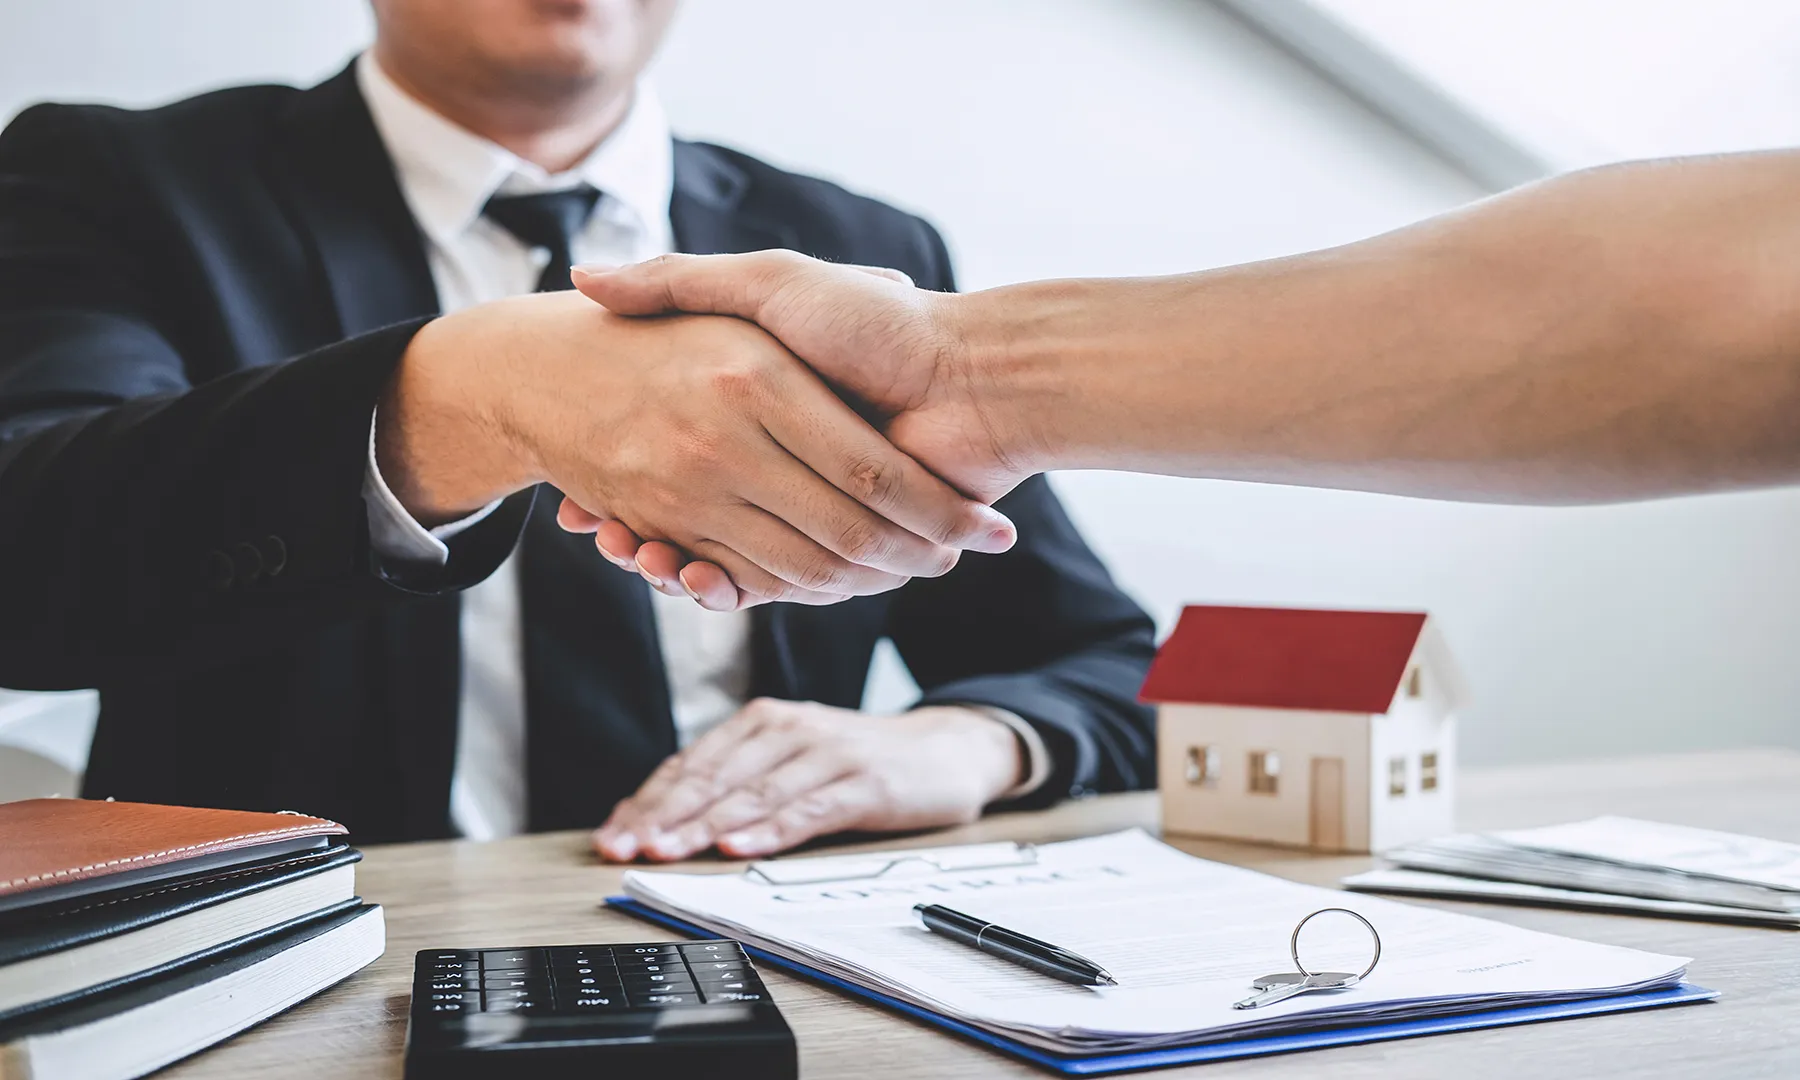

**Introduction:**

In today’s fast-paced financial world, loan approvals need to be both fast and reliable. Financial institutions face increasing pressure to make quick decisions while minimizing risk. This is where machine learning steps in—bringing automation, consistency, and data-driven insights to the process.

This project explores how we can use supervised learning techniques—specifically Extreme Gradient Boosting (XGBoost)—to predict loan approval outcomes. The goal is to simulate how banks or lenders might assess whether an applicant should be granted a loan, using historical data and a set of features like income, loan details, credit scores, and declared assets.

Instead of building complex financial simulations, this project keeps things straightforward: clean the data, extract key patterns, train a strong model, and evaluate how well it generalizes—especially on unseen, future data. The focus is both on performance and on making the model explainable, using tools like SHAP to understand how decisions are being made under the hood.

#### Preprocessing and Data Analysis

In [3]:
# Import all libraries and framework needed for the project.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report

from xgboost import XGBClassifier
from xgboost import plot_importance
import shap
from IPython.display import HTML
import joblib

In [4]:
# Basic matplotlib settings for some minor aesthetics.
plt.rcParams.update({
    'figure.figsize': (10, 6),
    'figure.facecolor': '#ecddd5',
    'axes.facecolor': '#ecddd5',
    'axes.edgecolor': '#1f1d2e',
    'axes.titlesize': 11,
    'axes.titleweight': 'light',
    'axes.grid': True,
    'axes.spines.top': False,
    'axes.spines.right': False, 
    'grid.linestyle': '-',
    'patch.linewidth': 0.2,
    'grid.color': '#2c0715',
    'grid.alpha': 0.1,
    'text.color': '#2c0715',
    'legend.loc': 'upper right',
    'xtick.color': '#2c0715',
    'ytick.color': '#2c0715',
    'axes.labelcolor': '#2c0715', 
})

rose = ['#2c0715', '#7f163d', '#c0949f', '#31748f', '#b95929']
cmap_color = ['#2c0715', '#c0949f', '#7f163d']
custom_cmap = ListedColormap(cmap_color)
sns.set_palette(rose)

In [5]:
# data source: https://www.kaggle.com/datasets/architsharma01/loan-approval-prediction-dataset
data = pd.read_csv("../data/raw.csv").set_index("loan_id")
print(data.shape)

data.head()

(4269, 12)


,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
loan_id,,,,,,,,,,,,
1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4269 entries, 1 to 4269
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0    no_of_dependents          4269 non-null   int64 
 1    education                 4269 non-null   object
 2    self_employed             4269 non-null   object
 3    income_annum              4269 non-null   int64 
 4    loan_amount               4269 non-null   int64 
 5    loan_term                 4269 non-null   int64 
 6    cibil_score               4269 non-null   int64 
 7    residential_assets_value  4269 non-null   int64 
 8    commercial_assets_value   4269 non-null   int64 
 9    luxury_assets_value       4269 non-null   int64 
 10   bank_asset_value          4269 non-null   int64 
 11   loan_status               4269 non-null   object
dtypes: int64(9), object(3)
memory usage: 433.6+ KB


In [7]:
data.columns

Index([' no_of_dependents', ' education', ' self_employed', ' income_annum',
       ' loan_amount', ' loan_term', ' cibil_score',
       ' residential_assets_value', ' commercial_assets_value',
       ' luxury_assets_value', ' bank_asset_value', ' loan_status'],
      dtype='object')

In [8]:
data.columns = data.columns.str.strip()
data.rename(columns={"cibil_score": "credit_score"}, inplace=True)
data.columns

Index(['no_of_dependents', 'education', 'self_employed', 'income_annum',
       'loan_amount', 'loan_term', 'credit_score', 'residential_assets_value',
       'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value',
       'loan_status'],
      dtype='object')

In [9]:
data.isna().sum()

no_of_dependents            0
education                   0
self_employed               0
income_annum                0
loan_amount                 0
loan_term                   0
credit_score                0
residential_assets_value    0
commercial_assets_value     0
luxury_assets_value         0
bank_asset_value            0
loan_status                 0
dtype: int64

In [10]:
data.duplicated().sum()

0

In [11]:
data["education"].value_counts()

education
Graduate        2144
Not Graduate    2125
Name: count, dtype: int64

In [12]:
data["self_employed"].value_counts()

self_employed
Yes    2150
No     2119
Name: count, dtype: int64

In [13]:
data["loan_status"].value_counts(normalize = True)

loan_status
Approved    0.62216
Rejected    0.37784
Name: proportion, dtype: float64

In [14]:
data["education"] = data["education"].str.strip().str.title()
data["self_employed"] = data["self_employed"].str.strip().str.title()
data["loan_status"] = data["loan_status"].str.strip().str.title()

data["education"] = data["education"].map({"Not Graduate": 0, "Graduate": 1})
data["self_employed"] = data["self_employed"].map({"No": 0, "Yes": 1})
data["loan_status"] = data["loan_status"].map({"Rejected": 0, "Approved": 1})

data.head()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,credit_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
loan_id,,,,,,,,,,,,
1,2,1,0,9600000,29900000,12,778,2400000,17600000,22700000,8000000,1
2,0,0,1,4100000,12200000,8,417,2700000,2200000,8800000,3300000,0
3,3,1,0,9100000,29700000,20,506,7100000,4500000,33300000,12800000,0
4,3,1,0,8200000,30700000,8,467,18200000,3300000,23300000,7900000,0
5,5,0,1,9800000,24200000,20,382,12400000,8200000,29400000,5000000,0


In [15]:
train = data.iloc[:3415].copy()
test = data.iloc[3415:].copy()

In [16]:
train["loan_status"].value_counts(normalize = True)
train.to_csv("../data/train.csv", index=False)

In [17]:
test["loan_status"].value_counts(normalize = True)
train.to_csv("../data/test.csv", index=False)

### Preprocessing Steps

- The dataset is of a manageable size, consisting of 12 columns and 4,269 rows.  
- It contains no duplicate entries or missing values, which simplifies initial cleaning.  
- The primary issue identified was the presence of leading and trailing spaces in column names, as well as leading spaces in some categorical values.

### Data Cleaning and Preparation

- Applied string manipulation methods (e.g., `.strip()`) to remove unwanted whitespace from column names and categorical entries.  
- Encoded binary categorical variables into numerical format (0 and 1) to facilitate model training.  
- Split the dataset into training and testing subsets to evaluate model performance and prevent data leakage.

In [19]:
first_half = ['no_of_dependents', 'education', 'self_employed', 'income_annum',
       'loan_amount', 'loan_term', 'loan_status']

second_half = ['credit_score', 'residential_assets_value',
       'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value',
       'loan_status']

<Figure size 1200x600 with 0 Axes>

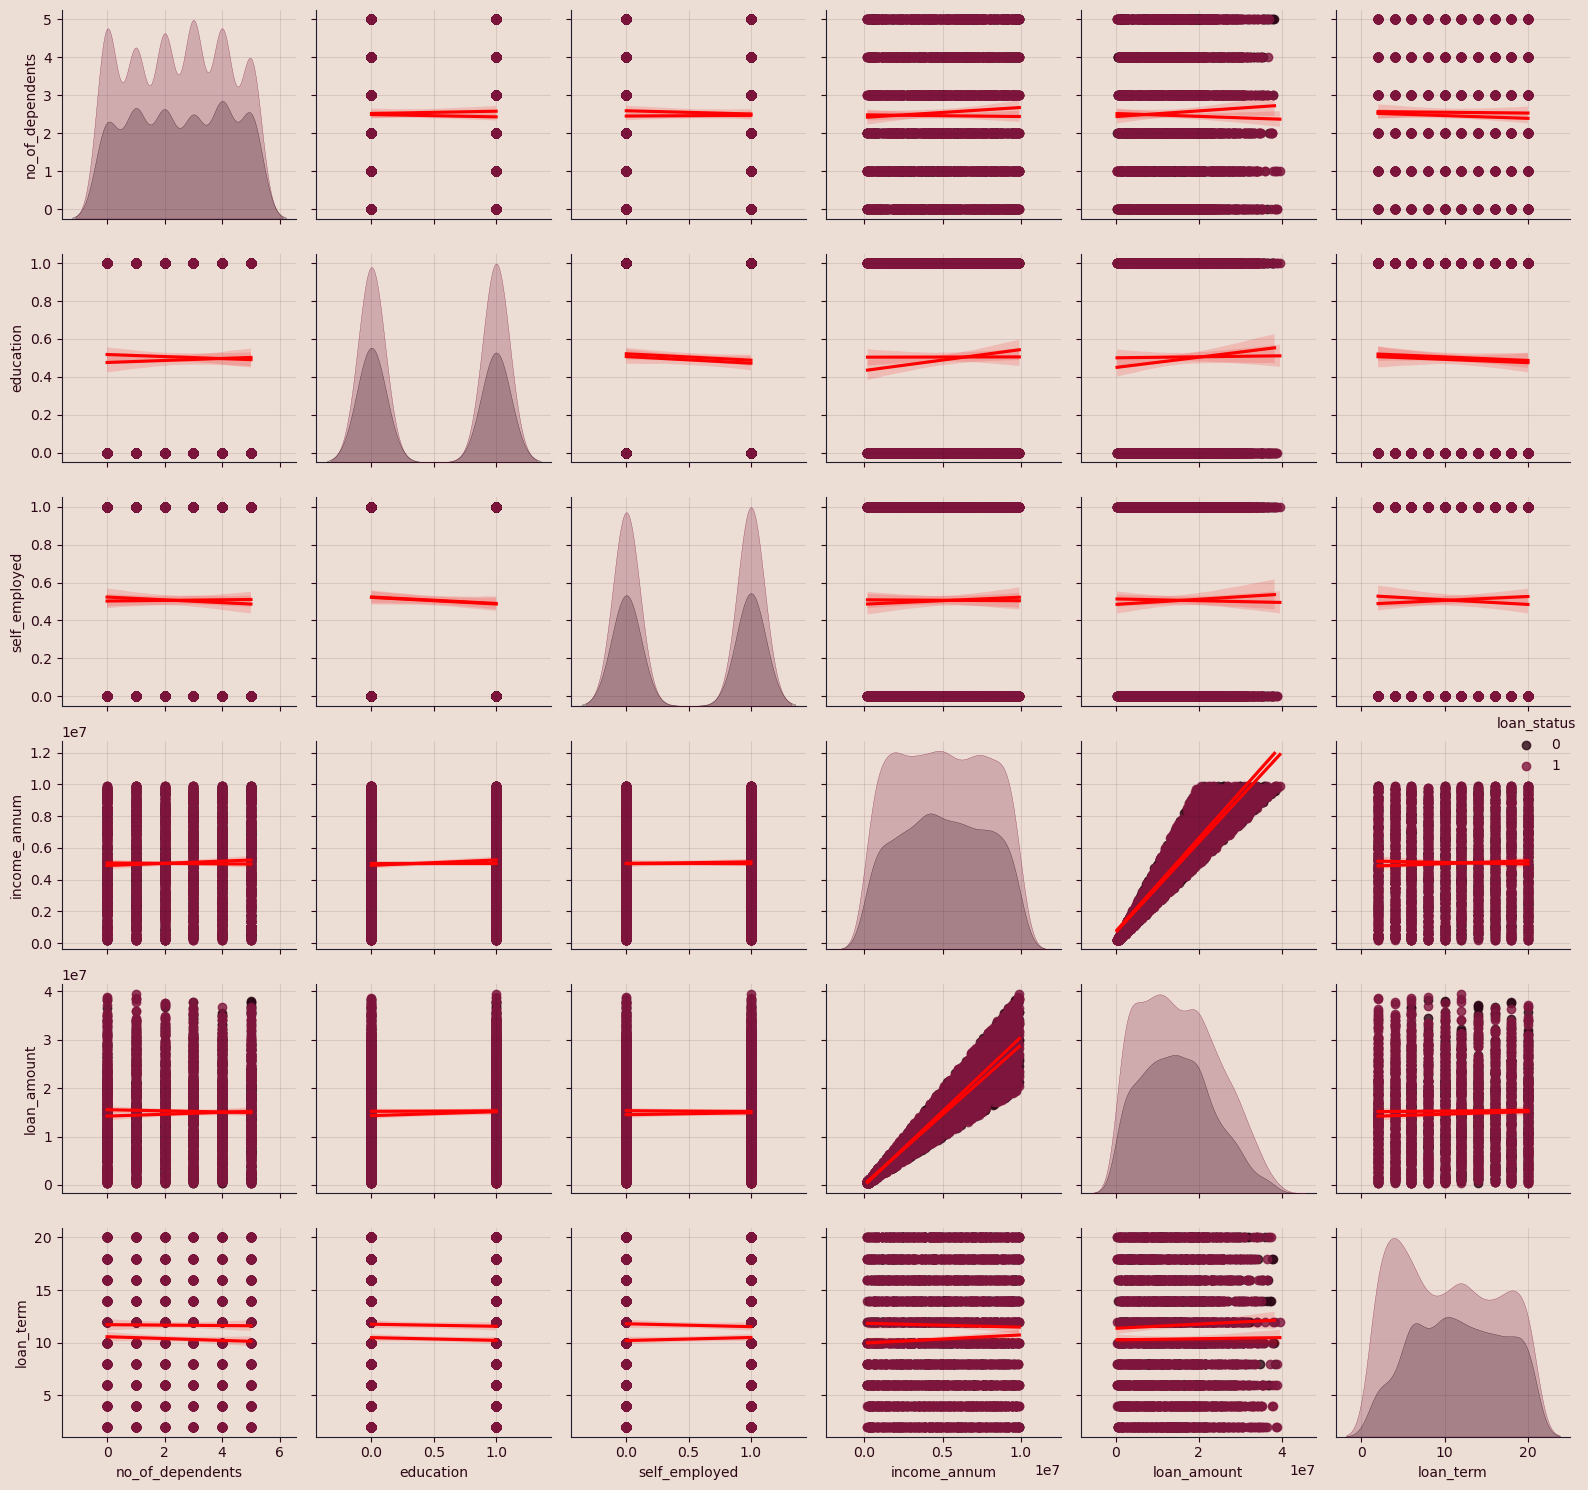

In [20]:
plt.figure(figsize = (12, 6))

sns.pairplot(train[first_half], hue="loan_status", kind="reg", plot_kws={"line_kws": {"color": "red"}})

plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

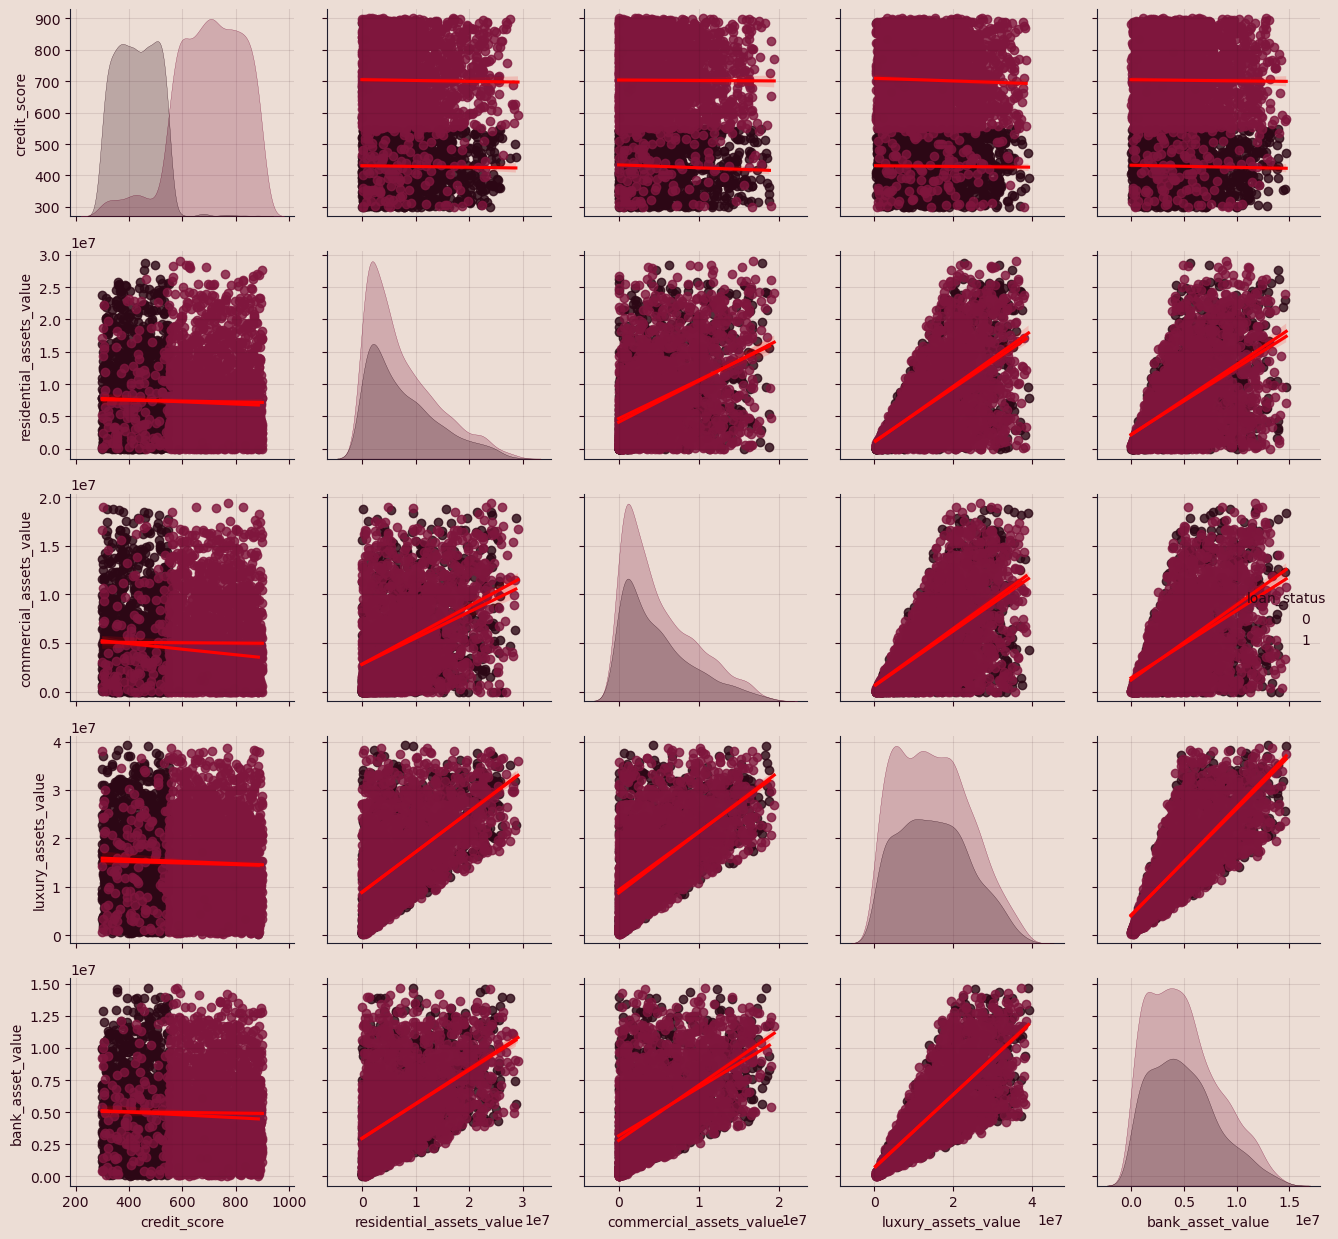

In [21]:
plt.figure(figsize = (12, 6))

sns.pairplot(train[second_half], hue="loan_status", kind="reg", plot_kws={"line_kws": {"color": "red"}})

plt.tight_layout()
plt.show()

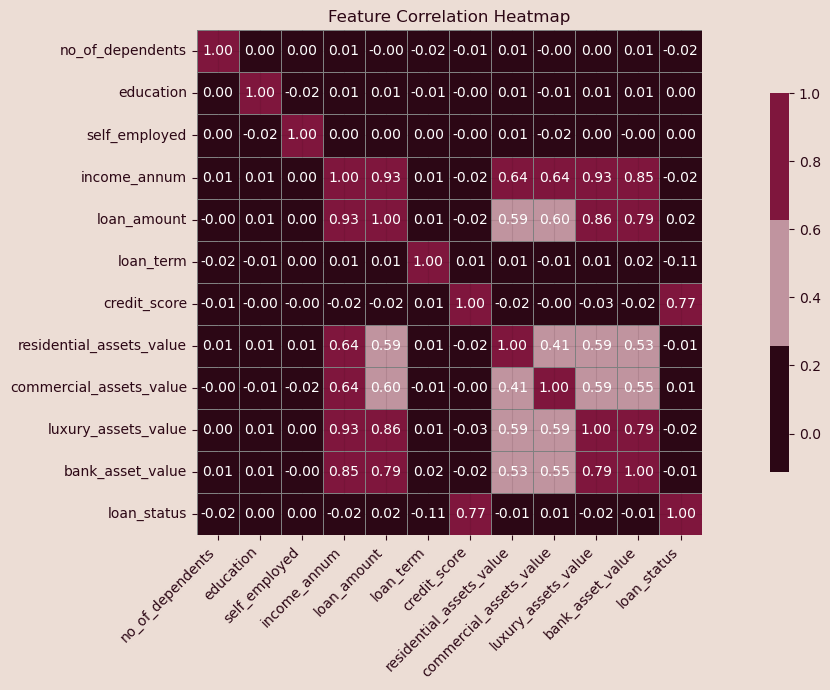

In [22]:
corr_matrix = data.corr()

plt.figure(figsize=(14, 7))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap=custom_cmap,
    square=True,
    cbar_kws={"shrink": 0.75},
    linewidths=0.5,
    linecolor="gray"
)

plt.title("Feature Correlation Heatmap", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [23]:
data["loan_amount"].describe()

count    4.269000e+03
mean     1.513345e+07
std      9.043363e+06
min      3.000000e+05
25%      7.700000e+06
50%      1.450000e+07
75%      2.150000e+07
max      3.950000e+07
Name: loan_amount, dtype: float64

In [24]:
data.columns

Index(['no_of_dependents', 'education', 'self_employed', 'income_annum',
       'loan_amount', 'loan_term', 'credit_score', 'residential_assets_value',
       'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value',
       'loan_status'],
      dtype='object')

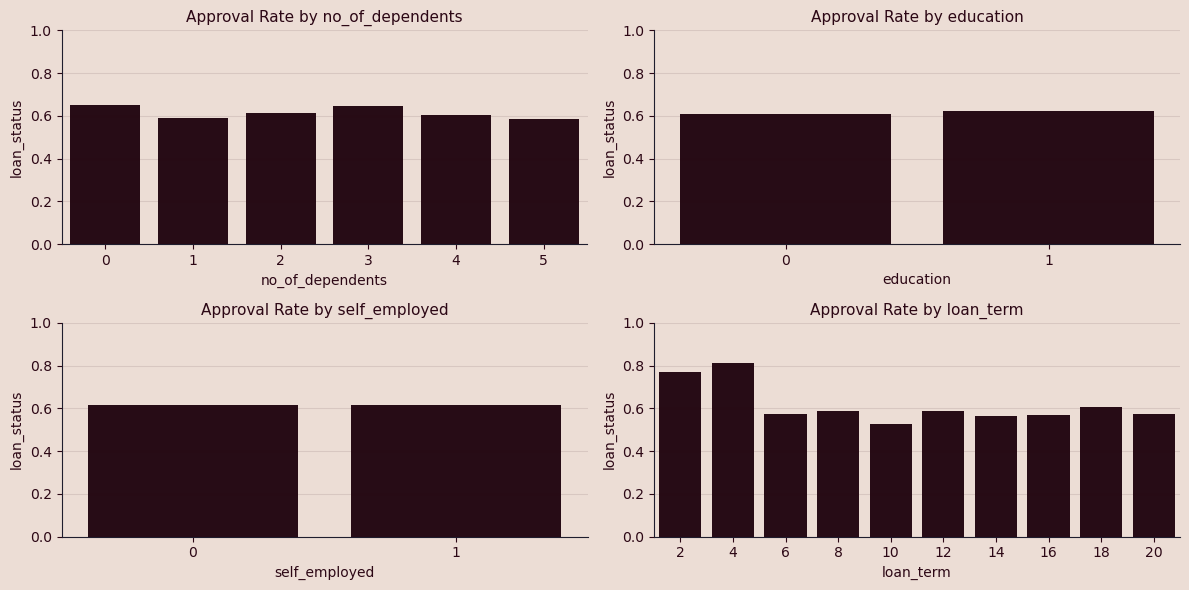

In [25]:
cols = ['no_of_dependents', 'education', 'self_employed', 'loan_term']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))
axes = axes.flatten()

for i, col in enumerate(cols):
    approval_rate = train.groupby(col)["loan_status"].mean().reset_index()
    
    sns.barplot(data=approval_rate, x=col, y="loan_status", ax=axes[i])
    axes[i].set_title(f"Approval Rate by {col}")
    axes[i].set_ylim(0, 1)

plt.tight_layout()
plt.show()

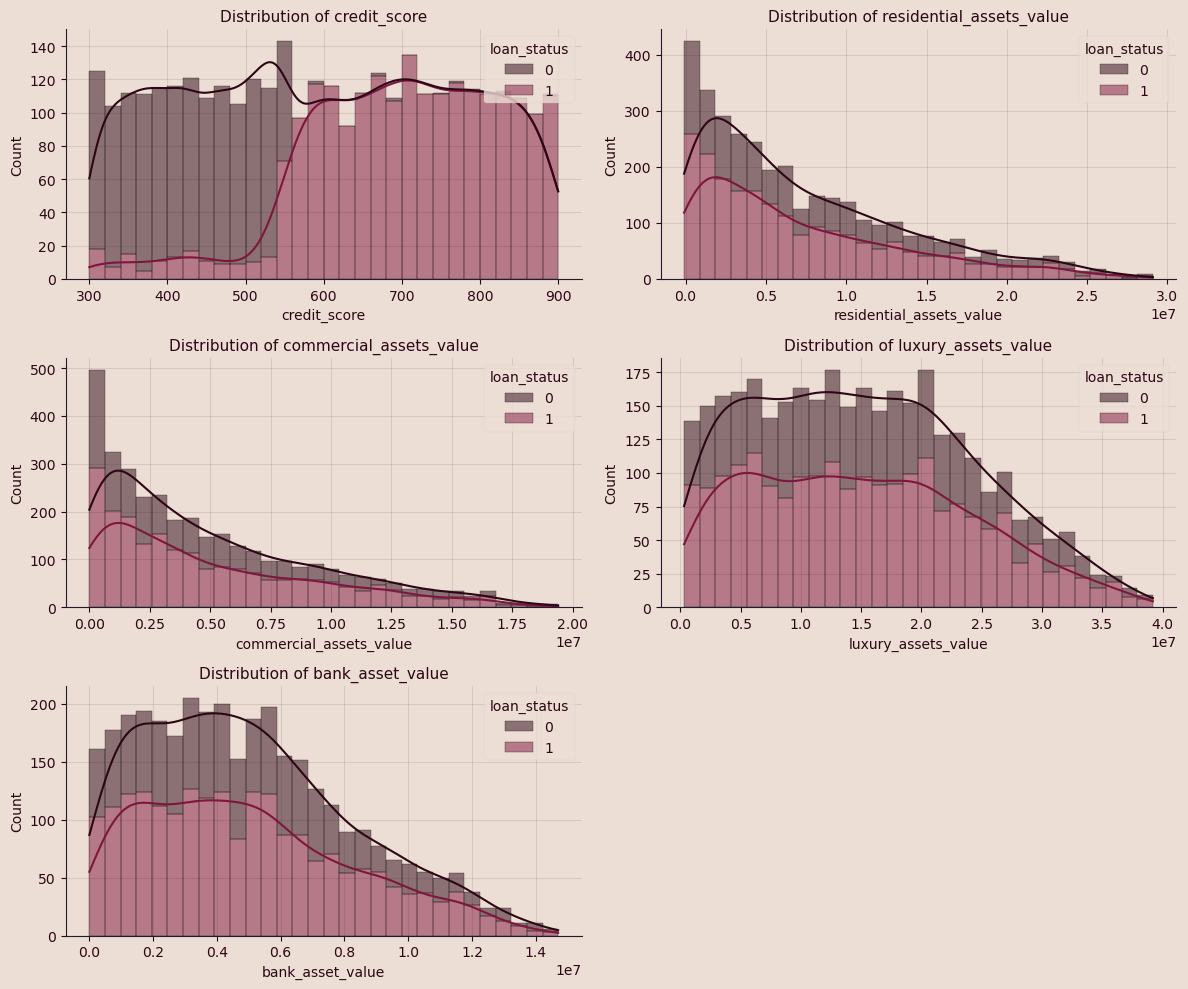

In [26]:
cols = ['credit_score', 'residential_assets_value',
        'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value']

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
axes = axes.flatten()

for i, col in enumerate(cols):
    sns.histplot(train, x=col, bins=30, kde=True, hue="loan_status", multiple="stack", ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_ylabel("Count")
    axes[i].set_xlabel(col)

fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

### Data Analysis Steps

- Utilized **pairplots** to explore trends and distribution shapes between the target variable and all features. To maintain readability and reduce visual clutter, the data was analyzed in two separate batches.
- Conducted **bivariate analysis** to examine loan approval rates across key categorical variables such as self-employment status, education level, number of dependents, and loan terms. The goal was to identify any potential biases or disproportionate influences in the data.
- Employed **histograms** to visualize the distribution of approved vs. rejected applications based on numerical attributes, including assets and credit scores.


### Insights

#### **Loan Approval vs. Personal Attributes**

There appears to be no significant difference in loan approval rates across categories such as:
- Number of dependents  
- Education level (Graduate vs. Not Graduate)  
- Self-employment status  

This suggests that these personal attributes may not have a strong influence on loan approval decisions.

#### **Loan Term Impact**

Applicants opting for **shorter loan terms (2 or 4 years)** show noticeably higher approval rates. This trend may reflect a lender preference for lower-risk, shorter-term financial commitments.

#### **Credit Score Importance**

A **credit score above 550** significantly improves the likelihood of loan approval. This is consistent with expectations, as creditworthiness remains a primary factor in evaluating loan risk.

#### **Income Effect**

There is a clear positive correlation between **income level** and loan approval. Applicants with higher incomes or financial assets are more likely to be approved, indicating a lender preference for financially stable individuals.


In [28]:
X = train.drop("loan_status", axis=1) 
y = train["loan_status"]
mi_scores = mutual_info_classif(X, y, discrete_features='auto')

mi_table = pd.DataFrame({
    'Feature': X.columns,
    'MI Score': mi_scores
})

mi_table = mi_table.sort_values(by='MI Score', ascending=False).reset_index(drop=True)

print(mi_table)

                     Feature  MI Score
0               credit_score  0.509360
1                  loan_term  0.012083
2               income_annum  0.010426
3           no_of_dependents  0.005581
4              self_employed  0.005543
5        luxury_assets_value  0.004660
6                  education  0.000000
7                loan_amount  0.000000
8   residential_assets_value  0.000000
9    commercial_assets_value  0.000000
10          bank_asset_value  0.000000


### Feature Engineering & Feature Selection

### Feature Selection Rationale

Based on our data analysis, **loan approval does not appear to be significantly influenced by personal attributes** such as education level, self-employment status, or number of dependents. Instead, the key factors influencing approval are aligned with the applicant's **financial credibility and ability to repay the loan**. These findings suggest that the loan approval process prioritizes objective financial indicators over personal demographics.

To reflect this insight, we will engineer and select features that directly measure the borrower's repayment capacity and financial stability. The selected criteria include:

1. **Credit Score** – A critical indicator of creditworthiness and past repayment behavior.  
2. **Debt-to-Income Ratio** – Reflects the borrower’s ability to repay by comparing debt obligations to income.  
3. **Asset Value** – Ensures the borrower has sufficient collateral, which provides security to the lender in case of default.

We will develop features that represent these criteria to guide our modeling process and align with how decisions are made in real-world lending scenarios.


In [31]:
train["monthly_installment"] = train["loan_amount"] / (train["loan_term"] * 12)
train["monthly_income"] = train["income_annum"] / 12
train["installment_to_income_ratio"] = train["monthly_installment"] / train["monthly_income"]

train["total_asset"] = train[['residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value']].sum(axis = 1)
train["collateral_sufficient"] = (train["total_asset"] >= train["loan_amount"]).astype(int)


features = ["credit_score", "installment_to_income_ratio", "collateral_sufficient"]

In [32]:
print(train[features].describe())

       credit_score  installment_to_income_ratio  collateral_sufficient
count   3415.000000                  3415.000000            3415.000000
mean     597.748755                     0.437321               0.993851
std      172.246239                     0.401394               0.078188
min      300.000000                     0.075000               0.000000
25%      449.000000                     0.188338               1.000000
50%      596.000000                     0.277778               1.000000
75%      745.000000                     0.507035               1.000000
max      900.000000                     2.000000               1.000000


In [33]:
train.groupby("collateral_sufficient")["loan_status"].mean()

collateral_sufficient
0    0.000000
1    0.619034
Name: loan_status, dtype: float64

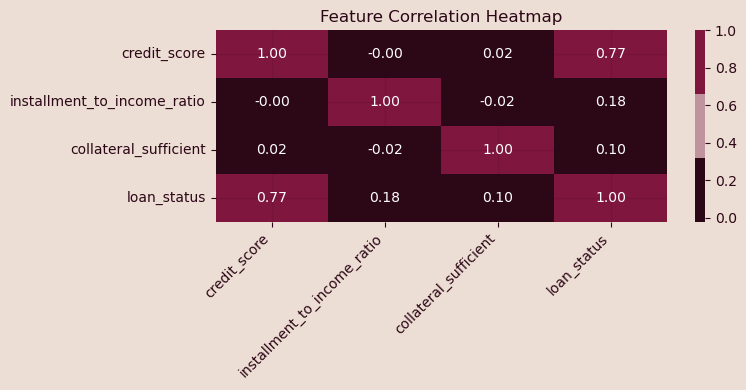

In [34]:
plt.figure(figsize = (8, 4))

sns.heatmap(train[["credit_score", "installment_to_income_ratio", "collateral_sufficient", "loan_status"]].corr(), 
            fmt=".2f",
            annot=True, 
            cmap=custom_cmap
)

plt.title("Feature Correlation Heatmap", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Model Training and Testing

In [36]:
X = train[features]
y = train["loan_status"]

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=69)
model = XGBClassifier(random_state=69)
fold = 1
reports = []

for train_index, val_index in skf.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:,1]

    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_proba)
    report = classification_report(y_val, y_pred, output_dict=True)
    
    reports.append({"fold": fold,
                    "accuracy": acc,
                    "f1_score": f1,
                    "roc_auc": roc_auc,
                    "classification_report": report
                   })

    print(f"Fold {fold} done: Acc={acc:.5f}, F1={f1:.5f}, AUC={roc_auc:.5f}")
    fold += 1

Fold 1 done: Acc=0.99415, F1=0.99526, AUC=0.99986
Fold 2 done: Acc=0.99123, F1=0.99287, AUC=0.99971
Fold 3 done: Acc=0.99415, F1=0.99522, AUC=0.99993
Fold 4 done: Acc=0.99123, F1=0.99284, AUC=0.99989
Fold 5 done: Acc=0.99123, F1=0.99287, AUC=0.99978
Fold 6 done: Acc=0.99707, F1=0.99762, AUC=1.00000
Fold 7 done: Acc=1.00000, F1=1.00000, AUC=1.00000
Fold 8 done: Acc=0.99413, F1=0.99526, AUC=0.99967
Fold 9 done: Acc=0.99707, F1=0.99762, AUC=1.00000
Fold 10 done: Acc=0.99120, F1=0.99284, AUC=0.99969


In [37]:
df_report = pd.DataFrame(reports)

summary = pd.DataFrame([{
    "Accuracy": r["accuracy"],
    "F1 Score": r["f1_score"],
    "ROC AUC": r["roc_auc"]
} for r in reports])

print("\nAverage Metrics Across Folds:")
print(summary.mean(numeric_only=True))


Average Metrics Across Folds:
Accuracy    0.994146
F1 Score    0.995241
ROC AUC     0.999853
dtype: float64


In [38]:
df_report

,fold,accuracy,f1_score,roc_auc,classification_report
0,1,0.994152,0.995261,0.999855,"{'0': {'precision': 0.9923664122137404, 'recal..."
1,2,0.991228,0.992874,0.999711,"{'0': {'precision': 0.9923664122137404, 'recal..."
2,3,0.994152,0.995215,0.999928,"{'0': {'precision': 0.9850746268656716, 'recal..."
3,4,0.991228,0.992840,0.999892,"{'0': {'precision': 0.9849624060150376, 'recal..."
4,5,0.991228,0.992874,0.999784,"{'0': {'precision': 0.9923664122137404, 'recal..."
5,6,0.997067,0.997625,1.000000,"{'0': {'precision': 1.0, 'recall': 0.992366412..."
6,7,1.000000,1.000000,1.000000,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc..."
7,8,0.994135,0.995261,0.999673,"{'0': {'precision': 1.0, 'recall': 0.984732824..."
8,9,0.997067,0.997625,1.000000,"{'0': {'precision': 1.0, 'recall': 0.992366412..."
9,10,0.991202,0.992840,0.999691,"{'0': {'precision': 0.9848484848484849, 'recal..."


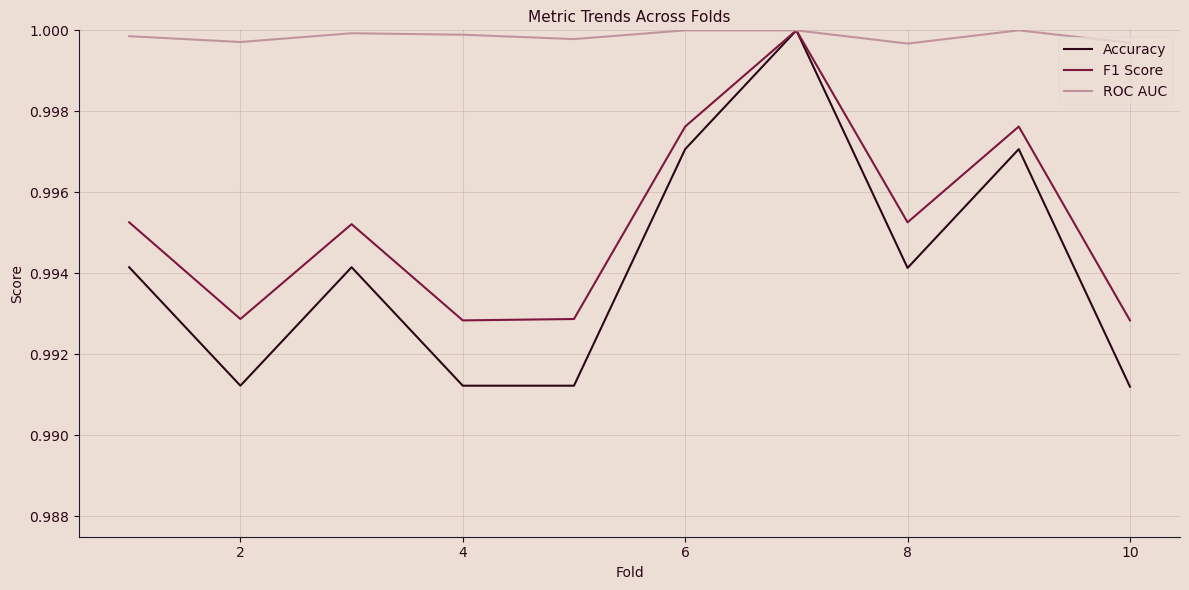

In [39]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_report, x='fold', y='accuracy', label='Accuracy')
sns.lineplot(data=df_report, x='fold', y='f1_score', label='F1 Score')
sns.lineplot(data=df_report, x='fold', y='roc_auc', label='ROC AUC')
plt.ylim(0.9875, 1)
plt.title("Metric Trends Across Folds")
plt.xlabel("Fold")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

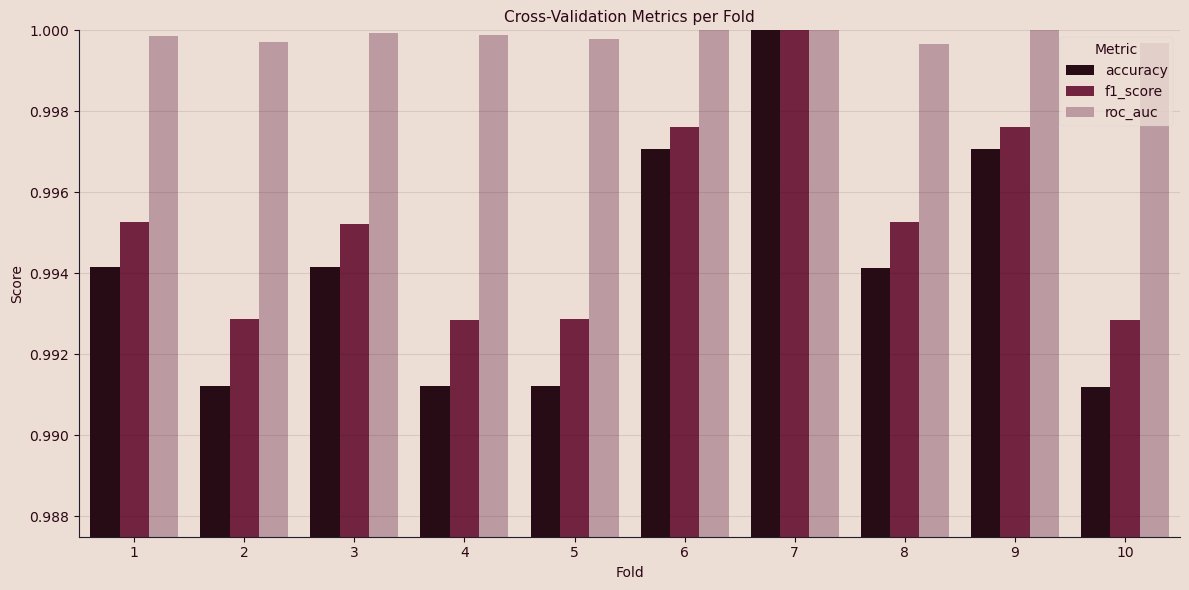

In [40]:
df_report = pd.DataFrame(reports)

plt.figure(figsize=(12, 6))
df_melted = df_report.melt(id_vars='fold', value_vars=['accuracy', 'f1_score', 'roc_auc'],
                           var_name='Metric', value_name='Score')

sns.barplot(data=df_melted, x='fold', y='Score', hue='Metric')
plt.ylim(0.9875, 1)
plt.title("Cross-Validation Metrics per Fold")
plt.ylabel("Score")
plt.xlabel("Fold")
plt.legend(title="Metric")
plt.tight_layout()

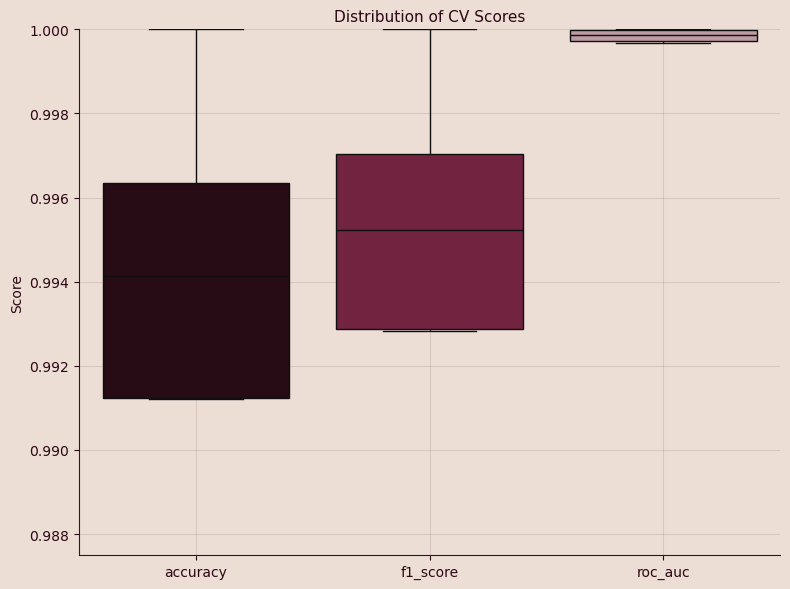

In [41]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_report[['accuracy', 'f1_score', 'roc_auc']])
plt.title("Distribution of CV Scores")
plt.ylabel("Score")
plt.ylim(0.9875, 1)
plt.grid(True)
plt.tight_layout()
plt.show()

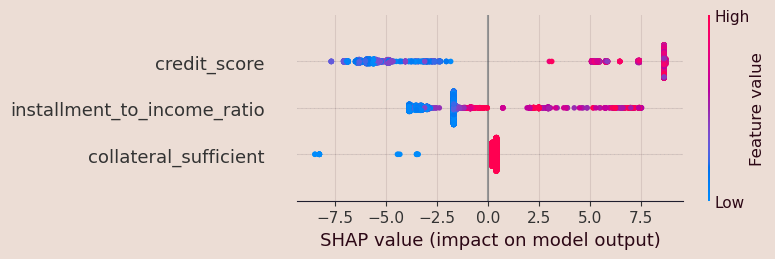

In [42]:
shap.initjs()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)


force_plot = shap.force_plot(explainer.expected_value, shap_values[0,:], X_val.iloc[0,:])

html = f"""
<div style="background-color: #ecddd5; color: black; padding: 10px;">
{force_plot.html()}
</div>
"""

display(HTML(html))
shap.summary_plot(shap_values, X_train)

### Model Training and Evaluation

- Utilized **Stratified K-Fold cross-validation** to address minor class imbalances while ensuring representative splits across folds.
- Performed a **manual 10-fold cross-validation**, recording key performance metrics such as **accuracy**, **F1-score**, and **ROC AUC** for each fold.
- Visualized the results of all 10 cross-validation folds to identify performance trends, assess metric distributions, and compare the model's behavior across the three core classification metrics.

### Insights

- The model demonstrated **consistently strong performance**, suggesting that the **feature engineering strategy was highly effective**, even without hyperparameter tuning.
- Among all features, a **credit score of 417** emerged as the most influential predictor of loan approval.  
- **Sufficient collateral value** provided a moderate additional boost to prediction confidence.  
- Interestingly, an **income-to-debt ratio of 0.372** appeared to negatively impact the approval prediction, indicating a potential lender concern over repayment capacity relative to debt obligations.

#### Prediction

In [45]:
test["monthly_installment"] = test["loan_amount"] / (test["loan_term"] * 12)
test["monthly_income"] = test["income_annum"] / 12
test["installment_to_income_ratio"] = test["monthly_installment"] / test["monthly_income"]

test["total_asset"] = test[['residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value']].sum(axis = 1)
test["collateral_sufficient"] = (test["total_asset"] >= test["loan_amount"]).astype(int)

features = ["credit_score", "installment_to_income_ratio", "collateral_sufficient"]
X_test = test[features]
y_test = test["loan_status"]

In [46]:
# Predicting on test data
model.fit(X, y)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {acc:.5f}")
print(f"F1-Score: {f1:.5f}")
print(f"ROC-AUC: {roc_auc:.5f}")
print(report)

Accuracy: 0.99766
F1-Score: 0.99819
ROC-AUC: 0.99999
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       299
           1       1.00      1.00      1.00       555

    accuracy                           1.00       854
   macro avg       1.00      1.00      1.00       854
weighted avg       1.00      1.00      1.00       854



In [47]:
# Saving the model to be used on POC
joblib.dump(model, 'model.pkl')

['model.pkl']